In [11]:
import sys
from sys import argv

sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf,norm_logpmf,beta_logpdf,uniform_logpdf,poisson_logpmf

from matplotlib.backends.backend_pdf import PdfPages

In [12]:
def SIRH_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    hosp,D,mu,sig = model_params

    gamma = 1/1000
    L = 0.
    lam = 1/35
    sig_state = 0.005

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    for index in range(particles.shape[0]):

        new_S = ((L * particles[index,3,t]) * dt) 
        new_I = ((particles[index,4,t] * (particles[index,0,t] * particles[index,1,t])/np.sum(particles[index,:,t])) * dt)
        new_IH = ((D * gamma * particles[index,1,t]) * dt)
        new_HR = ((hosp * particles[index,2,t]) * dt)
        new_IR = ((D *(1 - gamma) * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] + new_S - new_I + sig_state/np.sum(particles[index,:,t]) * particles[index,0,t] * rng.normal(0,np.sqrt(dt)))
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - (new_IH + new_IR) + sig_state * particles[index,1,t] * rng.normal(0,np.sqrt(dt)))
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_IH - new_HR + sig_state * particles[index,2,t] * rng.normal(0,np.sqrt(dt)))
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_HR + new_IR - new_S + sig_state * particles[index,3,t] * rng.normal(0,np.sqrt(dt)))

        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SIRH_Obs(data_point, particle_observations, model_params):
    weights = poisson_logpmf(k = data_point,mu = particle_observations[:,0] + 0.005)
    return weights

def SIRH_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 7_329_000
    I_init = rng.integers(10_000,200_000,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,2] = 8
    particles_0[:,3] = 0
    particles_0[:,4] = rng.uniform(0.0,0.4, size = (num_particles,))
    
    return particles_0

In [13]:
data_2022 = pd.read_csv('./%Experiment_4_Real_Data_3_2022_run1/AZ_FLU_HOSPITALIZATIONS.csv',index_col = False).to_numpy().T[1]
data_2022 = np.expand_dims(data_2022[:140],0)

data_2023 = pd.read_csv('./%Experiment_4_Real_Data_3_2023_run1/AZ_FLU_HOSPITALIZATIONS.csv',index_col = False).to_numpy().T[1]
data_2023 = np.expand_dims(data_2023[:140],0)

t_vec = np.arange(0,140,1)

In [14]:
output_2022 = np.load('./%Experiment_4_Real_Data_3_2022_run1/Results/PMCMC_Output_7.npz')
output_2023 = np.load('./%Experiment_4_Real_Data_3_2023_run1/Results/PMCMC_Output_7.npz')
burn_in = 100_000
par_mean_2022 = np.mean((output_2022['accepted_params'][:,burn_in:]),axis = 1)
par_mean_2023 = np.mean((output_2023['accepted_params'][:,burn_in:]),axis = 1)

In [15]:
pf_params = {'num_particles':10_000, 
                    'dt':0.1,
                    'model':SIRH_model,
                    'observation_model':SIRH_Obs,
                    'model_dim':5,
                    'particle_initializer':SIRH_init
                    }

par = np.mean((output_2022['accepted_params'][:,burn_in:]),axis = 1)

pf_output_2022 = particlefilter(data = data_2022,
    model_params= par,
    pf_params = pf_params,
    rng = np.random.default_rng(0),
    req_jit=True
    )

pf_params = {'num_particles':10_000, 
                    'dt':0.1,
                    'model':SIRH_model,
                    'observation_model':SIRH_Obs,
                    'model_dim':5,
                    'particle_initializer':SIRH_init
                    }

par = np.mean((output_2023['accepted_params'][:,burn_in:]),axis = 1)

pf_output_2023 = particlefilter(data = data_2023,
    model_params= par,
    pf_params = pf_params,
    rng = np.random.default_rng(0),
    req_jit=True
    )

posterior mean eta 2022: 0.28046676717629276
posterior mean eta 2023: 0.21889705548377794
posterior std eta 2022: 0.0260478143187606
posterior std eta 2023: 0.015587669508530985
posterior mean alpha 2022: 0.13439194546488759
posterior mean alpha 2023: 0.1013785900980993
posterior std alpha 2022: 0.027720287180940772
posterior std alpha 2023: 0.02155867273191961


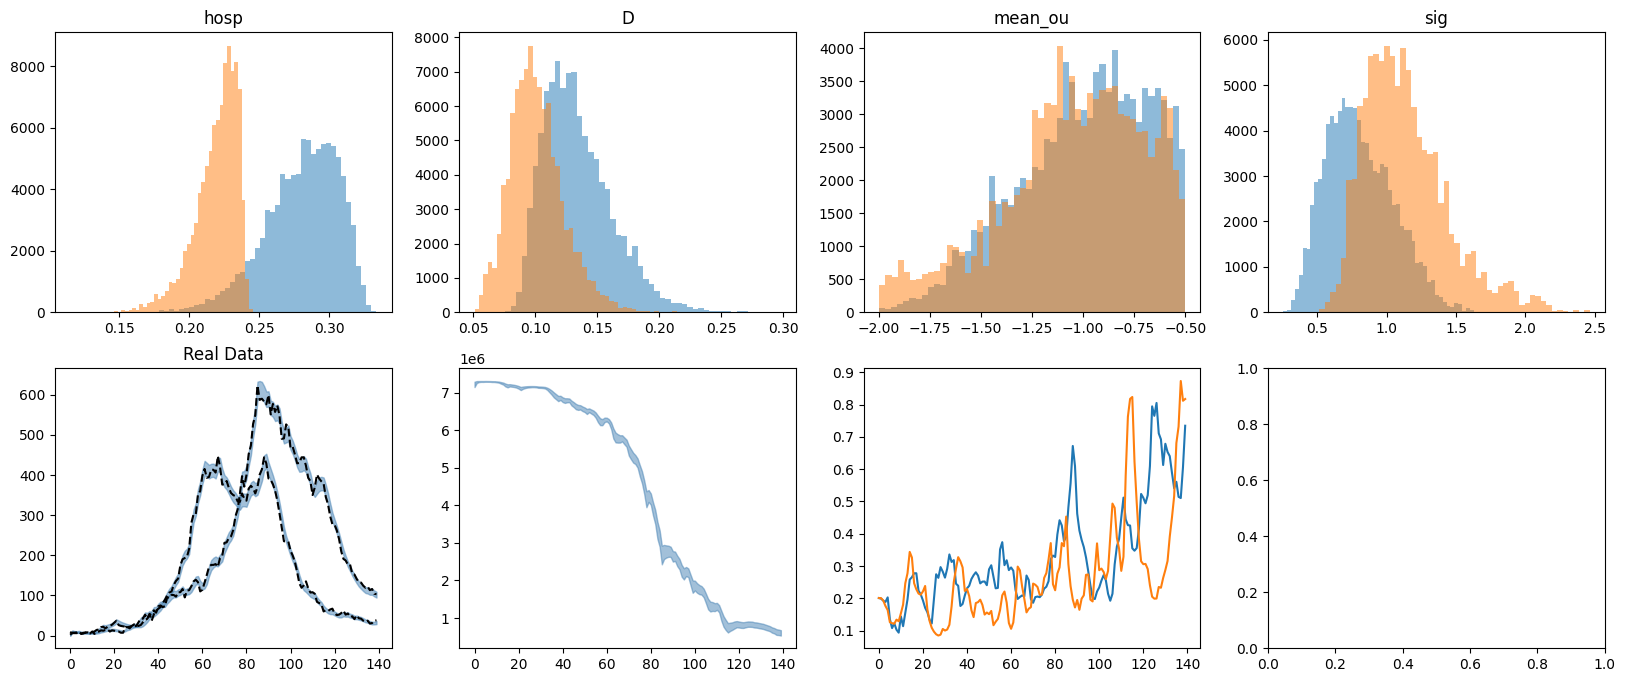

In [16]:
'''Ensemble parameter figure'''
param_names = ['hosp','D','mean_ou','sig']

fig,axs = plt.subplots(nrows = 2,ncols = 4,figsize = (20,8))

axs[0,0].hist(output_2022['accepted_params'][0,burn_in:],bins = 50,alpha = 0.5)
axs[0,0].hist(output_2023['accepted_params'][0,burn_in:],bins = 50,alpha = 0.5)
axs[0,0].set_title(f"hosp")
print(f"posterior mean eta 2022: {np.mean(output_2022['accepted_params'][0,burn_in:])}")
print(f"posterior mean eta 2023: {np.mean(output_2023['accepted_params'][0,burn_in:])}")
print(f"posterior std eta 2022: {np.std(output_2022['accepted_params'][0,burn_in:])}")
print(f"posterior std eta 2023: {np.std(output_2023['accepted_params'][0,burn_in:])}")


axs[0,1].hist(output_2022['accepted_params'][1,burn_in:],bins = 50,alpha = 0.5)
axs[0,1].hist(output_2023['accepted_params'][1,burn_in:],bins = 50,alpha = 0.5)
axs[0,1].set_title(f"D")
print(f"posterior mean alpha 2022: {np.mean(output_2022['accepted_params'][1,burn_in:])}")
print(f"posterior mean alpha 2023: {np.mean(output_2023['accepted_params'][1,burn_in:])}")
print(f"posterior std alpha 2022: {np.std(output_2022['accepted_params'][1,burn_in:])}")
print(f"posterior std alpha 2023: {np.std(output_2023['accepted_params'][1,burn_in:])}")


axs[0,2].hist((output_2022['accepted_params'][2,burn_in:]),bins = 50,alpha = 0.5)
axs[0,2].hist((output_2023['accepted_params'][2,burn_in:]),bins = 50,alpha = 0.5)
axs[0,2].set_title(f"mean_ou")

axs[0,3].hist((output_2022['accepted_params'][3,burn_in:]),bins = 50,alpha = 0.5)
axs[0,3].hist((output_2023['accepted_params'][3,burn_in:]),bins = 50,alpha = 0.5)
axs[0,3].set_title(f"sig")

axs[1,0].set_title('Real Data')
axs[1,0].fill_between(t_vec,
np.percentile(pf_output_2022['particle_observations'][:, 0, :].T, 12.5, axis=1),
np.percentile(pf_output_2022['particle_observations'][:, 0, :].T, 87.5, axis=1),
alpha=0.5, color='steelblue')
axs[1,0].fill_between(t_vec,
np.percentile(pf_output_2023['particle_observations'][:, 0, :].T, 12.5, axis=1),
np.percentile(pf_output_2023['particle_observations'][:, 0, :].T, 87.5, axis=1),
alpha=0.5, color='steelblue')

axs[1,0].plot(data_2022.T,'--',color = 'black')
axs[1,0].plot(data_2023.T,'--',color = 'black')

axs[1,1].fill_between(t_vec,
np.percentile(pf_output_2023['particle_distribution'][:, 0, :].T, 12.5, axis=1),
np.percentile(pf_output_2023['particle_distribution'][:, 0, :].T, 87.5, axis=1),
alpha=0.5, color='steelblue')

axs[1,2].plot(t_vec,np.mean(pf_output_2022['particle_distribution'][:, 4, :].T,axis = 1))
axs[1,2].plot(t_vec,np.mean(pf_output_2023['particle_distribution'][:, 4, :].T,axis = 1))




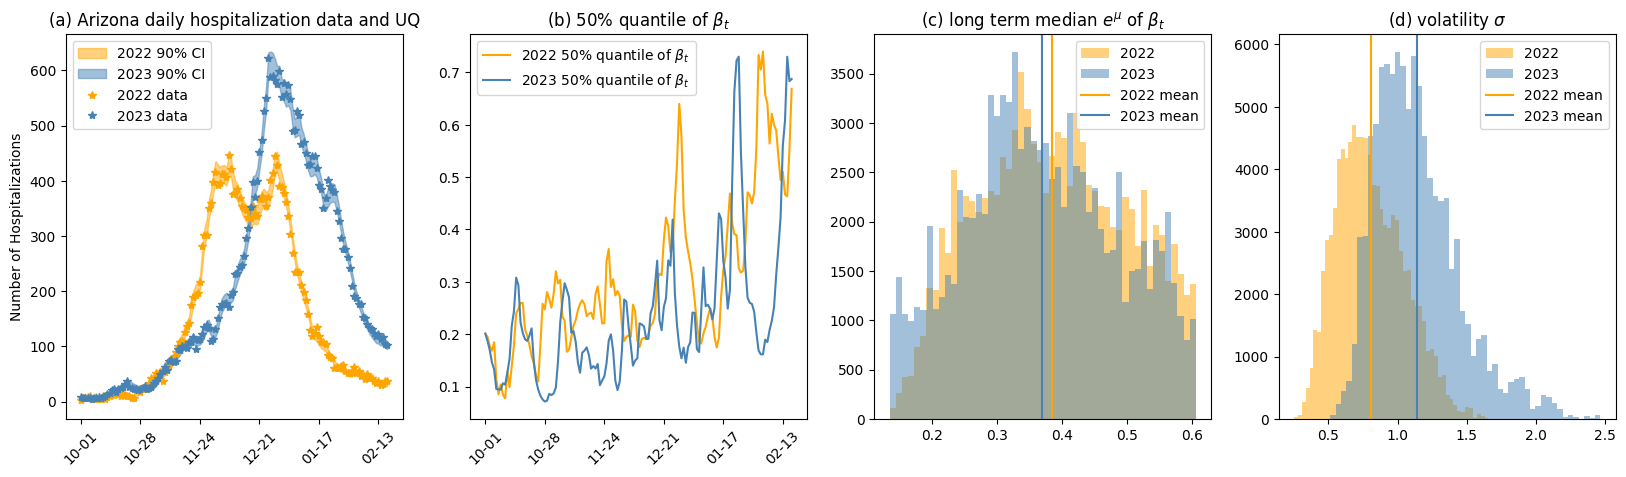

In [17]:
'''The figure from the paper.'''
import datetime

start_date = datetime.date(2000, 10, 1)
end_date = datetime.date(2001, 2, 13)
dates = []
for i in range(0,6):
    dates.append(start_date + datetime.timedelta(days = 27 * i))

date_labels = [date.strftime("%m-%d") for date in dates]

fig,axs = plt.subplots(nrows = 1,ncols = 4,figsize = (20,5))

axs[0].set_title('(a) Arizona daily hospitalization data and UQ')
axs[0].set_ylabel('Number of Hospitalizations')
axs[0].fill_between(t_vec,
np.percentile(pf_output_2022['particle_observations'][:, 0, :].T, 12.5, axis=1),
np.percentile(pf_output_2022['particle_observations'][:, 0, :].T, 87.5, axis=1),
alpha=0.5, color='orange',label = '2022 90% CI')
axs[0].fill_between(t_vec,
np.percentile(pf_output_2023['particle_observations'][:, 0, :].T, 12.5, axis=1),
np.percentile(pf_output_2023['particle_observations'][:, 0, :].T, 87.5, axis=1),
alpha=0.5, color='steelblue',label = '2023 90% CI')

axs[0].plot(data_2022.T,'*',color = 'orange',label = '2022 data')
axs[0].plot(data_2023.T,'*',color = 'steelblue',label = '2023 data')

axs[0].set_xticks(range(0,140,27))
axs[0].set_xticklabels(date_labels, rotation=45)
axs[0].legend()

axs[1].set_title(f'(b) 50% quantile of $\\beta_t$')
axs[1].plot(t_vec,np.percentile(pf_output_2022['particle_distribution'][:, 4, :].T,50,axis = 1),label = '2022 50% quantile of $\\beta_t$',color = 'orange')
axs[1].plot(t_vec,np.percentile(pf_output_2023['particle_distribution'][:, 4, :].T,50,axis = 1),label = '2023 50% quantile of $\\beta_t$',color = 'steelblue')
axs[1].set_xticks(range(0,140,27))
axs[1].set_xticklabels(date_labels, rotation=45)
axs[1].legend()

axs[2].hist(np.exp(output_2022['accepted_params'][2,burn_in:]),bins = 50,alpha = 0.5,label = '2022',color = 'orange')
axs[2].hist(np.exp(output_2023['accepted_params'][2,burn_in:]),bins = 50,alpha = 0.5,label = '2023',color = 'steelblue')
axs[2].set_title(f"(c) long term median $e^\\mu$ of $\\beta_t$")
axs[2].axvline(np.mean(np.exp(output_2022['accepted_params'][2,burn_in:]),axis = 0),label = '2022 mean',color = 'orange')
axs[2].axvline(np.mean(np.exp(output_2023['accepted_params'][2,burn_in:]),axis = 0),label = '2023 mean',color = 'steelblue')
axs[2].legend()

axs[3].hist((output_2022['accepted_params'][3,burn_in:]),bins = 50,alpha = 0.5,label = '2022',color = 'orange')
axs[3].hist((output_2023['accepted_params'][3,burn_in:]),bins = 50,alpha = 0.5,label = '2023',color = 'steelblue')
axs[3].axvline(np.mean((output_2022['accepted_params'][3,burn_in:]),axis = 0),label = '2022 mean',color = 'orange')
axs[3].axvline(np.mean((output_2023['accepted_params'][3,burn_in:]),axis = 0),label = '2023 mean',color = 'steelblue')
axs[3].set_title(f"(d) volatility $\\sigma$")
axs[3].legend()

fig.savefig('figures/plot_real_data_experiment.png', dpi=300)
plt.show()
plt.close(fig)


